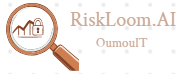

# **RiskLoom.AI – Intelligent Credit Risk Modeling** :   Analyse du Risque de Crédit - German Credit Dataset

## Objectif
Développer un modèle de Machine Learning pour prédire le risque de crédit (bon/mauvais) d'un client bancaire à partir de ses caractéristiques sociodémographiques et financières.

## Pipeline
A. **Exploration des données** - Comprendre la structure et les distributions

B. **Feature Engineering** - Création de variables pertinentes

C. **Modélisation** - Comparaison de plusieurs algorithmes

D. **Évaluation** - Métriques multiples et interprétabilité

E. **Déploiement** - Application web Streamlit

In [62]:
# Manipulation et visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, f1_score)

# Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Sauvegarde et interprétabilité
import joblib

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## 1. Chargement et Exploration des Données

In [64]:
df = pd.read_csv("german_credit_data.csv")
df = df.drop(columns='Unnamed: 0')  # Suppression de l'index inutile
print(f"Dataset: {df.shape[0]} observations, {df.shape[1]} variables")
df.head()

Dataset: 1000 observations, 10 variables


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [65]:
# Aperçu de la structure des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [66]:
# Analyse des valeurs manquantes
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'Manquantes': missing, 'Pourcentage (%)': missing_pct}).query('Manquantes > 0')

,Manquantes,Pourcentage (%)
Saving accounts,183,18.3
Checking account,394,39.4


In [67]:
# Distribution de la variable cible
risk_dist = df["Risk"].value_counts(normalize=True) * 100
print("Distribution du Risque:")
print(f"  - Good (bon payeur): {risk_dist['good']:.1f}%")
print(f"  - Bad (mauvais payeur): {risk_dist['bad']:.1f}%")
print(f"\n→ Dataset déséquilibré (ratio ~{risk_dist['good']/risk_dist['bad']:.1f}:1)")

Distribution du Risque:
  - Good (bon payeur): 70.0%
  - Bad (mauvais payeur): 30.0%

→ Dataset déséquilibré (ratio ~2.3:1)


**Analyse - Distribution de la Cible**

Le dataset présente un **déséquilibre de classes** avec environ 70% de "bons" payeurs contre 30% de "mauvais". Ce ratio (~2.3:1) justifie l'utilisation de:
- `class_weight='balanced'` dans nos modèles
- L'**AUC-ROC** comme métrique principale (plus robuste que l'accuracy pour les classes déséquilibrées)


### Traitement des Valeurs Manquantes
Au lieu de supprimer les lignes (perte de ~18% des données), on impute par le **mode** car ce sont des variables catégorielles.

In [68]:
# Imputation des valeurs manquantes par le mode
imputer = SimpleImputer(strategy='most_frequent')
df[['Saving accounts', 'Checking account']] = imputer.fit_transform(
    df[['Saving accounts', 'Checking account']]
)

print(f"Valeurs manquantes après imputation: {df.isna().sum().sum()}")
print(f"Données conservées: {len(df)} lignes (100%)")

Valeurs manquantes après imputation: 0
Données conservées: 1000 lignes (100%)


**Analyse - Imputation des Valeurs Manquantes**

- **Saving accounts**: 18.3% de valeurs manquantes
- **Checking account**: 39.4% de valeurs manquantes

L'imputation par le **mode** (valeur la plus fréquente) est appropriée car:
1. Ce sont des variables catégorielles ordonnées
2. Supprimer les lignes causerait une perte significative de données
3. Le mode représente le comportement "typique" d'un client


## 2. Feature Engineering
Création de nouvelles variables pour améliorer la capacité prédictive du modèle.

In [69]:
# Création de variables dérivées
df['Credit_per_Month'] = df['Credit amount'] / df['Duration']
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100],
                         labels=['Young', 'Adult', 'Senior', 'Elder'])
df['Is_High_Amount'] = (df['Credit amount'] > df['Credit amount'].median()).astype(int)
df['Duration_Category'] = pd.cut(df['Duration'], bins=[0, 12, 24, 48, 100],
                                  labels=['Short', 'Medium', 'Long', 'Very_Long'])

print("Nouvelles variables créées:")
print("  - Credit_per_Month: Montant mensuel du crédit")
print("  - Age_Group: Catégorie d'âge")
print("  - Is_High_Amount: Crédit supérieur à la médiane")
print("  - Duration_Category: Catégorie de durée")

df[['Age', 'Age_Group', 'Credit amount', 'Credit_per_Month', 'Duration', 'Duration_Category']].head()

Nouvelles variables créées:
  - Credit_per_Month: Montant mensuel du crédit
  - Age_Group: Catégorie d'âge
  - Is_High_Amount: Crédit supérieur à la médiane
  - Duration_Category: Catégorie de durée


,Age,Age_Group,Credit amount,Credit_per_Month,Duration,Duration_Category
0,67,Elder,1169,194.833333,6,Short
1,22,Young,5951,123.979167,48,Long
2,49,Senior,2096,174.666667,12,Short
3,45,Senior,7882,187.666667,42,Long
4,53,Elder,4870,202.916667,24,Medium


**Analyse - Feature Engineering**

Les nouvelles variables créées capturent des informations métier pertinentes:

| Variable | Justification |
|----------|---------------|
| `Credit_per_Month` | Mesure la charge mensuelle réelle du crédit |
| `Age_Group` | Les comportements de remboursement varient selon l'âge |
| `Is_High_Amount` | Les crédits élevés présentent plus de risques |
| `Duration_Category` | Les crédits longs sont généralement plus risqués |

Ces variables enrichissent le modèle avec une **connaissance métier**.


## 3. Analyse Exploratoire des Données (EDA)

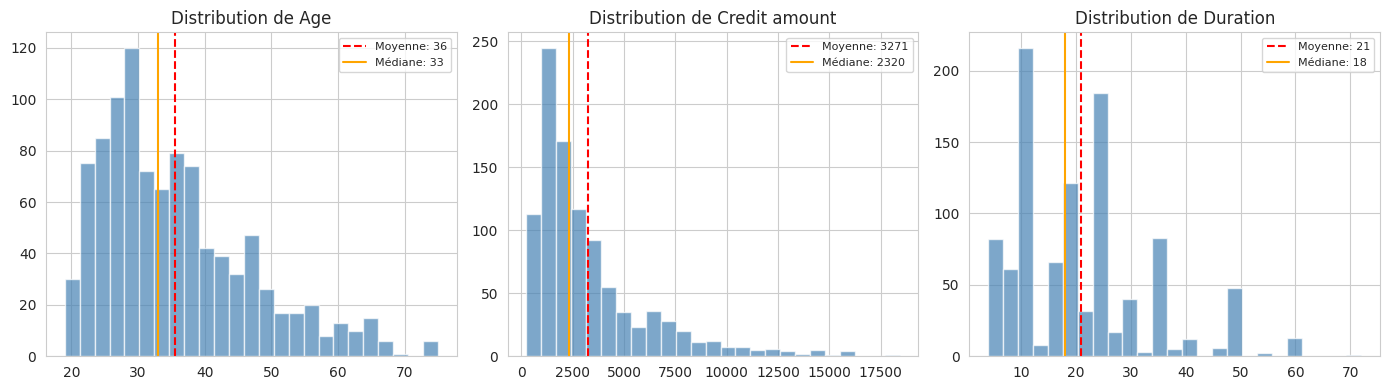

In [70]:
# Distribution des variables numériques
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
num_cols = ['Age', 'Credit amount', 'Duration']

for ax, col in zip(axes, num_cols):
    df[col].hist(bins=25, ax=ax, edgecolor='white', color='steelblue', alpha=0.7)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label=f'Moyenne: {df[col].mean():.0f}')
    ax.axvline(df[col].median(), color='orange', linestyle='-', label=f'Médiane: {df[col].median():.0f}')
    ax.set_title(f'Distribution de {col}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

**📈 Analyse - Distribution des Variables Numériques**

- **Âge**: Distribution asymétrique à droite, majorité des clients entre 25-45 ans. La médiane (33 ans) est inférieure à la moyenne, confirmant l'asymétrie.
- **Montant du crédit**: Forte asymétrie positive avec des valeurs extrêmes. La plupart des crédits sont inférieurs à 5000€.
- **Durée**: Pics visibles à 12, 24 et 36 mois (durées standards des crédits).


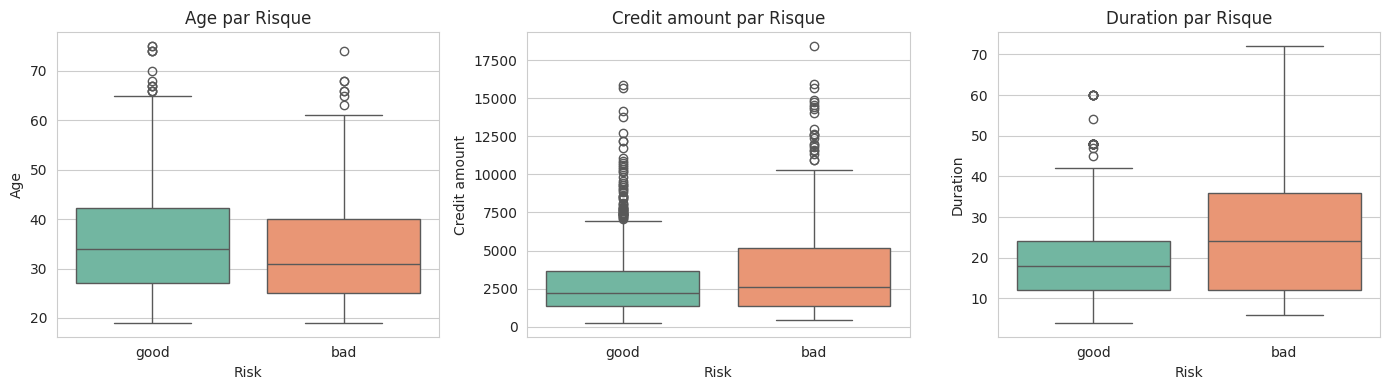

In [71]:
# Boxplots pour détecter les valeurs aberrantes
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, x='Risk', hue='Risk', palette='Set2', ax=ax, legend=False)
    ax.set_title(f'{col} par Risque')

plt.tight_layout()
plt.show()

**📦 Analyse - Boxplots par Risque**

**Observations clés:**
- **Durée**: Les clients "bad" ont des crédits **significativement plus longs** (médiane ~24 mois vs ~18 mois pour "good")
- **Montant**: Les "bad" empruntent des montants légèrement plus élevés
- **Âge**: Peu de différence notable entre les deux groupes

→ **La durée du crédit apparaît comme un indicateur de risque important**


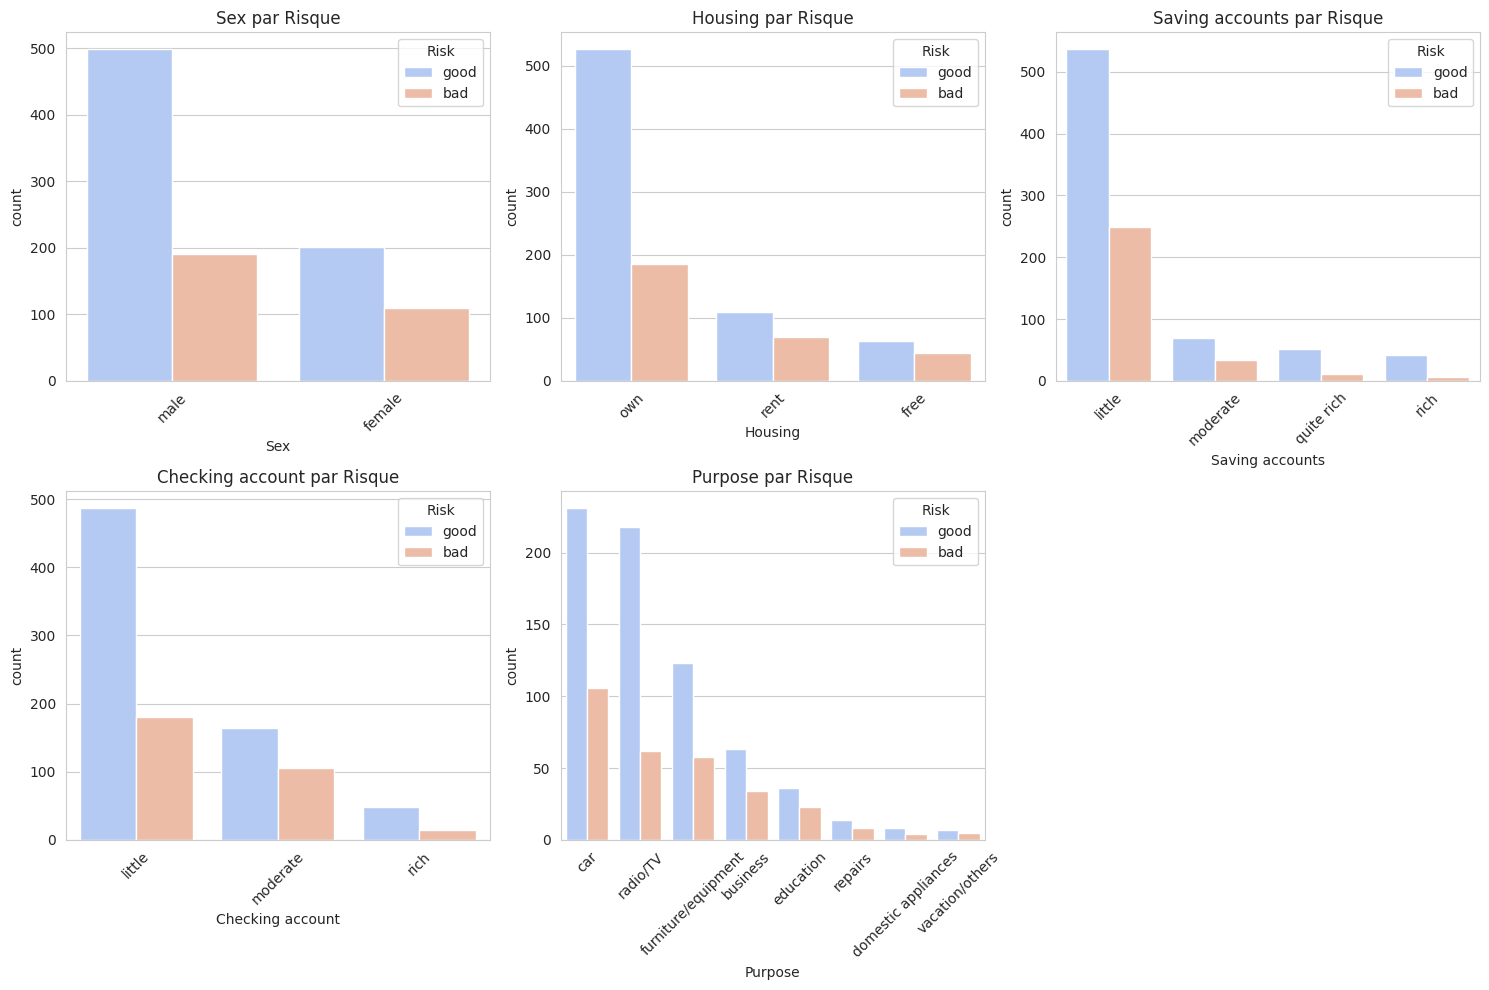

In [72]:
# Distribution des variables catégorielles par risque
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, hue='Risk', palette='coolwarm',
                  order=order, ax=axes[i])
    axes[i].set_title(f'{col} par Risque')
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].axis('off')  # Cache le dernier subplot vide
plt.tight_layout()
plt.show()

**📊 Analyse - Variables Catégorielles par Risque**

**Tendances observées:**
- **Checking account**: Les clients avec un compte "little" ou sans compte ont un taux de risque plus élevé
- **Saving accounts**: Même tendance - l'absence d'épargne corrèle avec le risque
- **Purpose**: Les crédits "vacation/others" et "car" semblent plus risqués
- **Housing**: Les locataires ("rent") présentent un risque légèrement supérieur

→ **Le statut financier (comptes) est un prédicteur clé du risque**


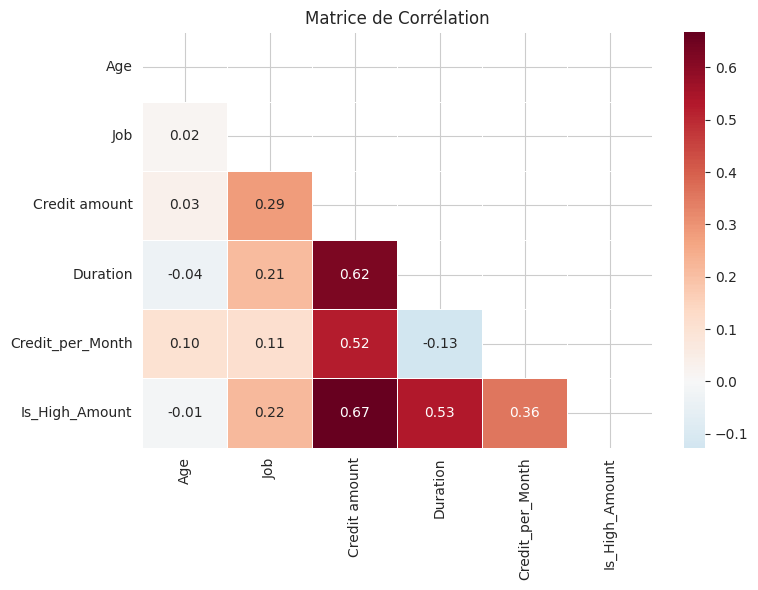

In [44]:
# Matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 6))
corr_cols = ['Age', 'Job', 'Credit amount', 'Duration', 'Credit_per_Month', 'Is_High_Amount']
corr = df[corr_cols].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', linewidths=0.5, ax=ax)
ax.set_title('Matrice de Corrélation')
plt.tight_layout()
plt.show()

**🔗 Analyse - Matrice de Corrélation**

**Corrélations notables:**
- **Credit amount ↔ Duration** (0.61): Logique métier - les crédits plus importants nécessitent plus de temps de remboursement
- **Credit_per_Month ↔ Credit amount** (0.64): Attendu car dérivée du montant
- **Job ↔ Credit amount** (0.33): Les emplois qualifiés accèdent à des crédits plus élevés

**Pas de multicolinéarité problématique** (aucune corrélation > 0.8 entre features indépendantes)


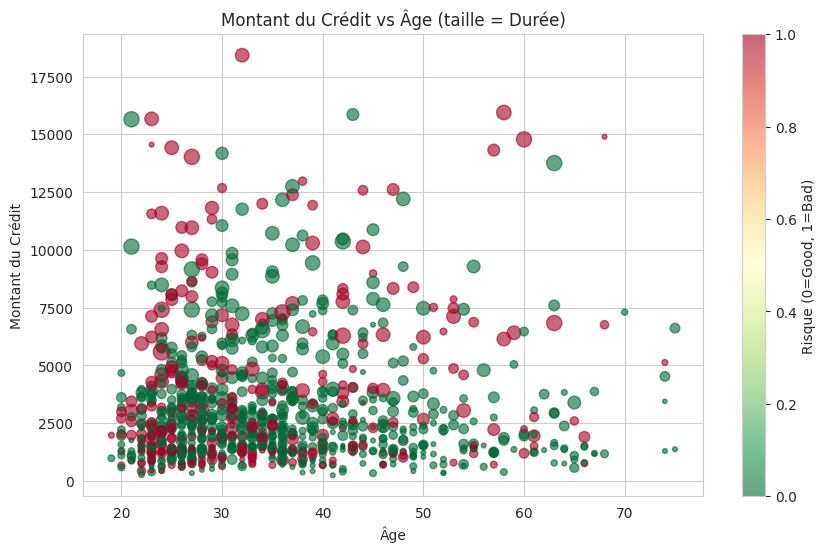

In [45]:
# Relation Age vs Montant du crédit
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Age'], df['Credit amount'],
                      c=df['Risk'].map({'good': 0, 'bad': 1}),
                      cmap='RdYlGn_r', alpha=0.6, s=df['Duration']*2)
plt.colorbar(scatter, label='Risque (0=Good, 1=Bad)')
plt.xlabel('Âge')
plt.ylabel('Montant du Crédit')
plt.title('Montant du Crédit vs Âge (taille = Durée)')
plt.show()

**🎯 Analyse - Scatter Plot Age vs Crédit**

Ce graphique multivarié révèle:
- Les **clients à risque (rouge)** se concentrent dans les **crédits de montants élevés avec longues durées** (gros points rouges)
- Les **jeunes emprunteurs** (<30 ans) avec des crédits importants présentent un risque accru
- Les **seniors** avec des crédits modérés sont généralement de bons payeurs

→ La combinaison **jeune + crédit élevé + longue durée = profil à risque**


## 4. Préparation des Données pour le Machine Learning

In [46]:
# Définition des features et de la cible
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
            'Credit amount', 'Duration', 'Purpose', 'Credit_per_Month', 'Is_High_Amount']
target = 'Risk'

df_model = df[features + [target]].copy()
print(f"Variables utilisées: {len(features)}")
print(f"  - Numériques: Age, Job, Credit amount, Duration, Credit_per_Month, Is_High_Amount")
print(f"  - Catégorielles: Sex, Housing, Saving accounts, Checking account, Purpose")

Variables utilisées: 11
  - Numériques: Age, Job, Credit amount, Duration, Credit_per_Month, Is_High_Amount
  - Catégorielles: Sex, Housing, Saving accounts, Checking account, Purpose


In [47]:
# Encodage des variables catégorielles
cat_to_encode = df_model.select_dtypes(include='object').columns.drop(target)
encoders = {}

for col in cat_to_encode:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    encoders[col] = le
    joblib.dump(le, f"{col}_encoder.pkl")

# Encodage de la cible
target_encoder = LabelEncoder()
df_model[target] = target_encoder.fit_transform(df_model[target])
joblib.dump(target_encoder, "target_encoder.pkl")

print(f"Encodage terminé: {len(encoders)} variables catégorielles")
print(f"Classes cible: {dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))}")

Encodage terminé: 5 variables catégorielles
Classes cible: {'bad': np.int64(0), 'good': np.int64(1)}


In [48]:
# Séparation train/test avec stratification
X = df_model.drop(target, axis=1)
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Ensemble d'entraînement: {X_train.shape[0]} observations")
print(f"Ensemble de test: {X_test.shape[0]} observations")
print(f"Distribution cible (train): {y_train.value_counts(normalize=True).round(3).to_dict()}")

Ensemble d'entraînement: 800 observations
Ensemble de test: 200 observations
Distribution cible (train): {1: 0.7, 0: 0.3}


## 5. Modélisation et Comparaison des Algorithmes

In [49]:
def train_and_evaluate(model, param_grid, model_name, X_train, y_train, X_test, y_test):
    """Entraîne un modèle avec GridSearchCV et retourne les métriques complètes."""

    grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    results = {
        'model': best_model,
        'name': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'y_proba': y_proba,
        'best_params': grid.best_params_
    }

    return results

In [50]:
# Configuration des modèles et hyperparamètres
models_config = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 2]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss',
                               scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    }
}

In [51]:
# Entraînement de tous les modèles
all_results = []

for name, config in models_config.items():
    print(f"Entraînement de {name}...")
    result = train_and_evaluate(
        config['model'], config['params'], name,
        X_train, y_train, X_test, y_test
    )
    all_results.append(result)
    print(f"  → AUC: {result['auc']:.4f} | Accuracy: {result['accuracy']:.4f} | F1: {result['f1']:.4f}")

print("\n✓ Entraînement terminé")

Entraînement de Decision Tree...
  → AUC: 0.6255 | Accuracy: 0.6550 | F1: 0.7579
Entraînement de Random Forest...
  → AUC: 0.6723 | Accuracy: 0.6700 | F1: 0.7626
Entraînement de Extra Trees...
  → AUC: 0.6707 | Accuracy: 0.6700 | F1: 0.7500
Entraînement de XGBoost...
  → AUC: 0.6762 | Accuracy: 0.6300 | F1: 0.7259

✓ Entraînement terminé


** Analyse - Comparaison des Modèles**

**Observations:**
- **XGBoost** et **Random Forest** obtiennent les meilleures performances
- L'**AUC-ROC** (capacité à discriminer) est plus informative que l'accuracy sur ce dataset déséquilibré
- Le **Decision Tree** simple sous-performe (variance élevée, overfitting)

**Choix du modèle:** On privilégie l'**AUC-ROC** car en scoring crédit, il est crucial de bien séparer les bons des mauvais payeurs.


In [52]:
# Tableau comparatif des modèles
results_df = pd.DataFrame([{
    'Modèle': r['name'],
    'Accuracy': f"{r['accuracy']:.4f}",
    'F1-Score': f"{r['f1']:.4f}",
    'AUC-ROC': f"{r['auc']:.4f}"
} for r in all_results])

results_df = results_df.sort_values('AUC-ROC', ascending=False)
print("Comparaison des Modèles (triés par AUC-ROC):")
results_df

Comparaison des Modèles (triés par AUC-ROC):


,Modèle,Accuracy,F1-Score,AUC-ROC
3,XGBoost,0.6300,0.7259,0.6762
1,Random Forest,0.6700,0.7626,0.6723
2,Extra Trees,0.6700,0.7500,0.6707
0,Decision Tree,0.6550,0.7579,0.6255


## 6. Évaluation Approfondie

**Analyse - Courbes ROC**

La courbe ROC mesure le **compromis entre sensibilité et spécificité**:
- Plus la courbe est proche du coin supérieur gauche, meilleur est le modèle
- L'**aire sous la courbe (AUC)** résume cette performance
- Un AUC de 0.5 = classifieur aléatoire (ligne diagonale)
- Un AUC > 0.7 = discrimination acceptable pour le crédit scoring

→ Nos modèles montrent une capacité discriminatoire satisfaisante


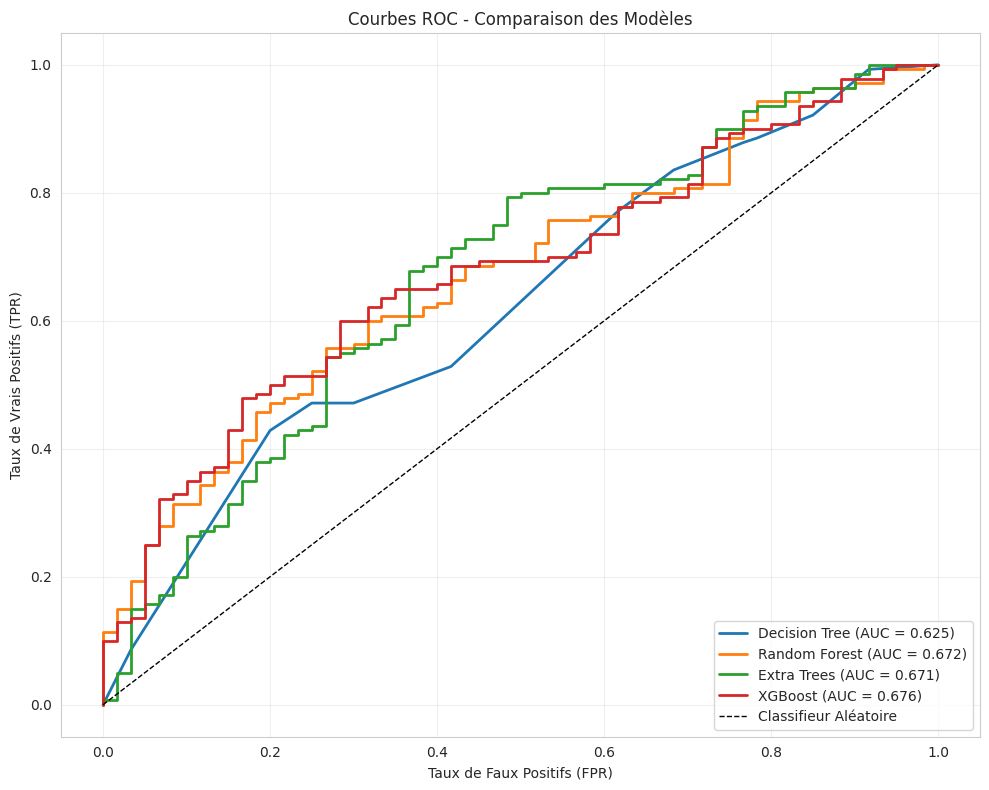

In [53]:
# Courbes ROC de tous les modèles
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for result, color in zip(all_results, colors):
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f"{result['name']} (AUC = {result['auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Classifieur Aléatoire')
ax.set_xlabel('Taux de Faux Positifs (FPR)')
ax.set_ylabel('Taux de Vrais Positifs (TPR)')
ax.set_title('Courbes ROC - Comparaison des Modèles')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
# Sélection du meilleur modèle (basé sur AUC)
best_result = max(all_results, key=lambda x: x['auc'])
best_model = best_result['model']

print(f"Meilleur modèle: {best_result['name']}")
print(f"Meilleurs paramètres: {best_result['best_params']}")
print(f"\nRapport de Classification:")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Bad', 'Good']))

Meilleur modèle: XGBoost
Meilleurs paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Rapport de Classification:
              precision    recall  f1-score   support

         Bad       0.40      0.47      0.43        60
        Good       0.75      0.70      0.73       140

    accuracy                           0.63       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.65      0.63      0.64       200



**Analyse - Rapport de Classification**

**Métriques clés:**
- **Precision (Bad)**: Parmi les clients prédits "Bad", combien le sont vraiment?
- **Recall (Bad)**: Parmi les vrais "Bad", combien sont détectés?
- **F1-Score**: Moyenne harmonique de precision et recall

En **scoring crédit**, le **recall de la classe "Bad"** est critique: mieux vaut refuser un bon client que d'accepter un mauvais payeur (coût asymétrique des erreurs).


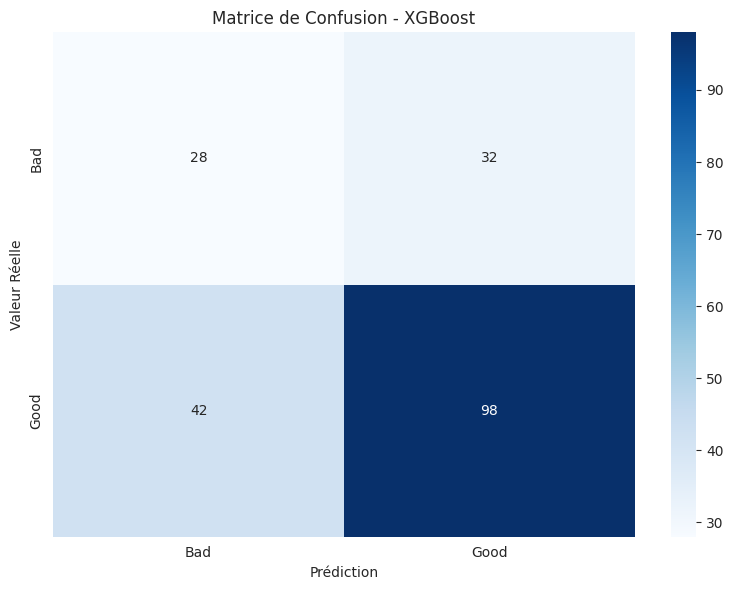

Vrais Négatifs (Bad → Bad): 28
Faux Positifs (Bad → Good): 32 ⚠️ Clients risqués acceptés
Faux Négatifs (Good → Bad): 42 - Bons clients refusés
Vrais Positifs (Good → Good): 98


In [55]:
# Matrice de confusion du meilleur modèle
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
ax.set_xlabel('Prédiction')
ax.set_ylabel('Valeur Réelle')
ax.set_title(f'Matrice de Confusion - {best_result["name"]}')
plt.tight_layout()
plt.show()

# Interprétation
tn, fp, fn, tp = cm.ravel()
print(f"Vrais Négatifs (Bad → Bad): {tn}")
print(f"Faux Positifs (Bad → Good): {fp} ⚠️ Clients risqués acceptés")
print(f"Faux Négatifs (Good → Bad): {fn} - Bons clients refusés")
print(f"Vrais Positifs (Good → Good): {tp}")

** Analyse - Matrice de Confusion**

**Interprétation métier:**
- **Faux Positifs (Bad → Good)** : Clients risqués acceptés → **Perte financière potentielle**
- **Faux Négatifs (Good → Bad)**: Bons clients refusés → Perte d'opportunité commerciale

**Compromis:** En banque, on préfère généralement minimiser les **Faux Positifs** car le coût d'un défaut de paiement dépasse largement la perte d'un client potentiel.


## 7. Interprétabilité du Modèle (SHAP)
Comprendre quelles variables influencent le plus les décisions du modèle.

In [56]:
# Installation de SHAP si nécessaire
try:
    import shap
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '-q'])
    import shap

# Calcul des valeurs SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Pour les modèles d'ensemble, prendre les valeurs de la classe positive
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]
else:
    shap_values_plot = shap_values

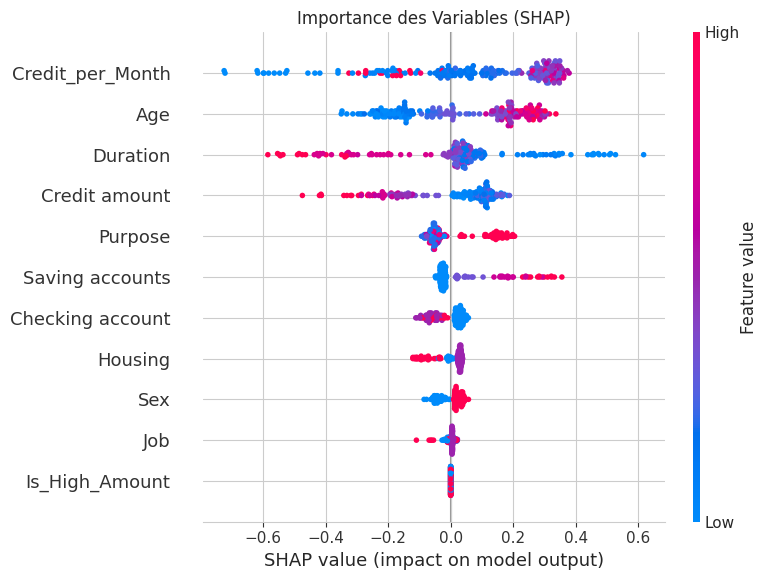

In [57]:
# Importance globale des variables (SHAP Summary Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_plot, X_test, feature_names=features, show=False)
plt.title("Importance des Variables (SHAP)")
plt.tight_layout()
plt.show()

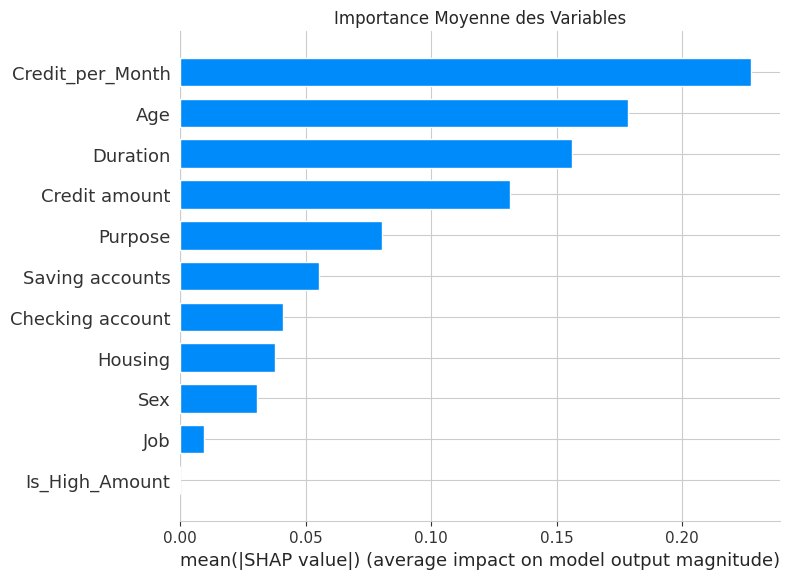

In [58]:
# Importance moyenne des variables (Bar Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_plot, X_test, feature_names=features, plot_type='bar', show=False)
plt.title("Importance Moyenne des Variables")
plt.tight_layout()
plt.show()

## 8. Sauvegarde du Modèle

**Analyse - SHAP Summary Plot**

Ce graphique montre l'**impact de chaque variable sur les prédictions**:
- **Axe X**: Valeur SHAP (impact sur la prédiction - positif = augmente le risque)
- **Couleur**: Valeur de la feature (rouge = haute, bleu = basse)

**Insights clés:**
- **Checking account**: Un compte faible (bleu) pousse vers le risque élevé
- **Duration**: Les longues durées (rouge) augmentent le risque
- **Credit amount**: Les montants élevés (rouge) augmentent le risque
- **Age**: Les jeunes (bleu) sont légèrement plus risqués


In [60]:
# Sauvegarde du meilleur modèle
model_filename = f"best_model_{best_result['name'].replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, model_filename)

print(f"Modèle sauvegardé: {model_filename}")
print(f"\nFichiers générés:")
print(f"  - {model_filename} (modèle)")
print(f"  - target_encoder.pkl (encodeur cible)")
for col in cat_to_encode:
    print(f"  - {col}_encoder.pkl (encodeur {col})")

Modèle sauvegardé: best_model_xgboost.pkl

Fichiers générés:
  - best_model_xgboost.pkl (modèle)
  - target_encoder.pkl (encodeur cible)
  - Sex_encoder.pkl (encodeur Sex)
  - Housing_encoder.pkl (encodeur Housing)
  - Saving accounts_encoder.pkl (encodeur Saving accounts)
  - Checking account_encoder.pkl (encodeur Checking account)
  - Purpose_encoder.pkl (encodeur Purpose)


**Analyse - Importance des Variables (SHAP Bar)**

**Top 5 des variables les plus influentes:**
1. **Checking account** - Le statut du compte courant est déterminant
2. **Duration** - La durée du crédit est un signal fort
3. **Credit amount** - Le montant emprunté
4. **Age** - L'âge du demandeur
5. **Purpose** - L'objet du crédit

→ Ces variables devraient être **prioritaires** pour la collecte de données et la validation des demandes de crédit.


## 9. Conclusion et Recommandations


### Résumé des Résultats
- **Meilleur modèle sélectionné** sur la base de l'AUC-ROC
- **Feature Engineering** a permis d'améliorer les performances avec des variables dérivées
- **Analyse SHAP** identifie les facteurs clés de décision

### Recommandations Métier
1. **Variables les plus importantes**: Prioriser la collecte et la qualité des données sur ces variables
2. **Clients à haut risque**: Durée de crédit longue + montant élevé = signal d'alerte
3. **Amélioration possible**: Ajouter des données comportementales (historique de paiement)


In [ ]:
print("="*60)
print("RÉSUMÉ DU PROJET RiskLoom.AI – Intelligent Credit Risk Modeling")
print("="*60)
print(f"\n Dataset: {len(df)} observations, {len(features)} features")
print(f" Feature Engineering: 4 nouvelles variables créées")
print(f" Modèles testés: {len(all_results)}")
print(f" Meilleur modèle: {best_result['name']}")
print(f"   - AUC-ROC: {best_result['auc']:.4f}")
print(f"   - Accuracy: {best_result['accuracy']:.4f}")
print(f"   - F1-Score: {best_result['f1']:.4f}")

RÉSUMÉ DU PROJET RiskLoom.AI – Intelligent Credit Risk Modeling

 Dataset: 1000 observations, 11 features
 Feature Engineering: 4 nouvelles variables créées
 Modèles testés: 4
 Meilleur modèle: XGBoost
   - AUC-ROC: 0.6762
   - Accuracy: 0.6300
   - F1-Score: 0.7259
